# Twitter Bot or Not? 

    ~~~~ Write a nice intro here

In [1]:
# Basics
import pandas as pd
import psycopg2 as pg
import numpy as np
from collections import Counter

# Visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from visualize import *
from model_evaluation import *

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Model support
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, auc,
                             plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve)

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

from yellowbrick.model_selection import FeatureImportances

/Users/scrapfish/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Data import and set up

In [2]:
# Postgres info to connect
connection_args = {
    'host': 'localhost',             # Connecting to _local_ version of psql
    'dbname': 'twitter_accounts',    # DB with Twitter info
    'port': 5432                     # port we opened on AWS
}

connection = pg.connect(**connection_args)

In [3]:
raw_df = pd.read_sql('SELECT * FROM human_bots', connection)

In [4]:
# drop funny index column
raw_df.drop(columns=['index'], inplace=True)

# Binary classifications for bots and boolean values
raw_df['bot'] = raw_df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile_image'] = raw_df['default_profile_image'].astype(int)
raw_df['geo_enabled'] = raw_df['geo_enabled'].astype(int)
raw_df['verified'] = raw_df['verified'].astype(int)

# datetime conversion
raw_df['created_at'] = pd.to_datetime(raw_df['created_at'])
# hour created
raw_df['hour_created'] = pd.to_datetime(raw_df['created_at']).dt.hour

In [5]:
# usable df setup
df = raw_df[['bot', 'screen_name', 'created_at', 'hour_created', 'verified', 'acct_location', 'geo_enabled', 'lang', 'default_profile', 
              'default_profile_image', 'favourites_count', 'followers_count', 'friends_count', 'statuses_count',
             'average_tweets_per_day', 'account_age_days']]

In [6]:
del raw_df

In [7]:
# Interesting features to look at: 
df['avg_daily_followers'] = np.round(df['followers_count'] / df['account_age_days'])
df['avg_daily_friends'] = np.round(df['followers_count'] / df['account_age_days'])
df['avg_daily_favorites'] = np.round(df['followers_count'] / df['account_age_days'])

# Log transformations for highly skewed data
df['friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df['favs_log'] = np.round(np.log(1 + df['favourites_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_day']), 3)

# Possible popularity metrics
df['popularity'] = np.round(df['friends_log'] * df['followers_log'], 3)
df['tweet_to_followers'] = np.round(np.log( 1+ df['statuses_count']) * np.log(1+ df['followers_count']), 3)

# Log-transformed daily acquisition metrics for dist. plots
df['follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['account_age_days'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)

In [8]:
features = ['verified', 
            #'created_at',
            #'hour_created',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'popularity', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df[features]
y = df['bot']

In [9]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=1234)

## Basic model evaluation

In [10]:
# Models that require scaling: 
knn = KNeighborsClassifier(n_neighbors=10)
lr = LogisticRegression()

# Scaling
scalar = StandardScaler()
scalar.fit(X)
X_train_scaled = scalar.transform(X)

model_list = [knn, lr]
kf = KFold(n_splits=5, shuffle=True, random_state=33)

In [11]:
multi_model_eval(model_list, X_train_scaled, y, kf)

Model: KNeighborsClassifier(n_neighbors=10)
------------------------------
Accuracy:  0.83767 +- 0.004042
Precision: 0.80131 +- 0.006912
Recall:    0.68362 +- 0.013989
F1 Score:  0.73768 +- 0.006909
ROC AUC:   0.89569 +- 0.003649

Model: LogisticRegression()
------------------------------
Accuracy:  0.80314 +- 0.002075
Precision: 0.71114 +- 0.006977
Recall:    0.69157 +- 0.010010
F1 Score:  0.70113 +- 0.003798
ROC AUC:   0.85181 +- 0.002741



In [12]:
# Models that don't require scaling
gnb = gnb = GaussianNB()
tree = DecisionTreeClassifier()
forest = RandomForestClassifier()
xgb = XGBClassifier()

model_list = [gnb, tree, forest, xgb]
kf = KFold(n_splits=3, shuffle=True, random_state=33)

In [13]:
multi_model_eval(model_list, X, y, kf)

Model: GaussianNB()
------------------------------
Accuracy:  0.69503 +- 0.059328
Precision: 0.55385 +- 0.090251
Recall:    0.82332 +- 0.138664
F1 Score:  0.64431 +- 0.011958
ROC AUC:   0.82068 +- 0.002617

Model: DecisionTreeClassifier()
------------------------------
Accuracy:  0.80939 +- 0.002353
Precision: 0.71024 +- 0.000315
Recall:    0.72512 +- 0.005673
F1 Score:  0.71759 +- 0.002855
ROC AUC:   0.78837 +- 0.002933

Model: RandomForestClassifier()
------------------------------
Accuracy:  0.86770 +- 0.001160
Precision: 0.84300 +- 0.008357
Recall:    0.74226 +- 0.007224
F1 Score:  0.78936 +- 0.000730
ROC AUC:   0.92475 +- 0.002663

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints

RandomForest and XGBoost seem most promising. 

Will look at ROC Curve for each next. 

Average AUC Score: 0.9262 +- 0.003707


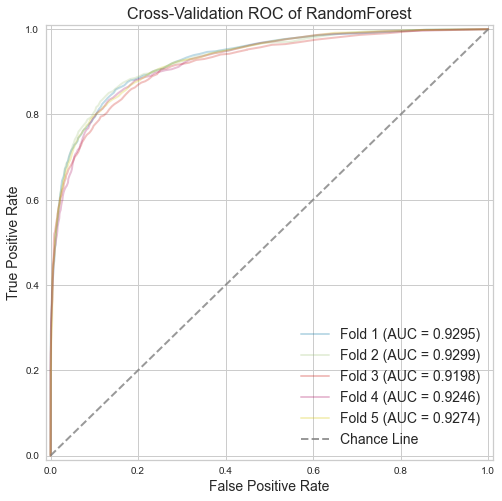

In [14]:
forest = RandomForestClassifier()
kf = KFold(n_splits=5, shuffle=True, random_state=33)

roc_curve_cv(forest, X, y, kf, model_alias='RandomForest')

Average AUC Score: 0.9274 +- 0.004188


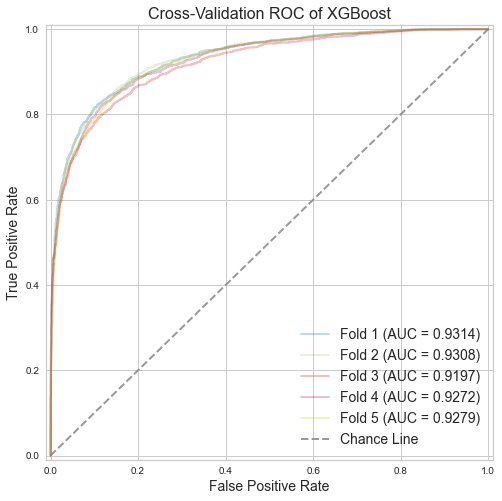

In [15]:
xgb = XGBClassifier()

kf = KFold(n_splits=5, shuffle=True, random_state=33)

roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

## Class weight balancing

In [16]:
num_bots = len(df[df['bot'] == 1])
num_humans = len(df[df['bot'] == 0])

print("Number of bots: ", num_bots)
print("Number of humans: ", num_humans)
print(f'Bots / Total %: {(num_bots / len(df))*100:.2f}')

Number of bots:  12425
Number of humans:  25013
Bots / Total %: 33.19


In [17]:
# For XGBoost
estimate = num_humans/num_bots
estimate

2.013118712273642

In [18]:
forest = RandomForestClassifier(class_weight='balanced')
xgb = XGBClassifier(scale_pos_weight=estimate)

models = [forest, xgb]
kf = KFold(n_splits=5, shuffle=True, random_state=33)

In [19]:
multi_model_eval(models, X, y, kf)

Model: RandomForestClassifier(class_weight='balanced')
------------------------------
Accuracy:  0.86938 +- 0.004366
Precision: 0.85113 +- 0.012318
Recall:    0.73799 +- 0.006881
F1 Score:  0.79049 +- 0.007551
ROC AUC:   0.92592 +- 0.003899

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.013118712273642,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
------------------------------
Accuracy:  0.86152 +- 0.004743
Precision: 0.78358 +- 0.009921
Recall:    0.80858 +- 0.007697
F1 Score:  0.79

XGBoost stands out as the clear winner here.

Let's look at a confusion matrix.

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3333)

In [21]:
xgb = XGBClassifier(scale_pos_weight=estimate)

xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)

Classification Metrics Report
-----------------------------
Accuracy:  0.8571
Precision: 0.7723
Recall:    0.7969
F1 Score:  0.7844

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      4415
           1       0.77      0.80      0.78      2137

    accuracy                           0.86      6552
   macro avg       0.84      0.84      0.84      6552
weighted avg       0.86      0.86      0.86      6552




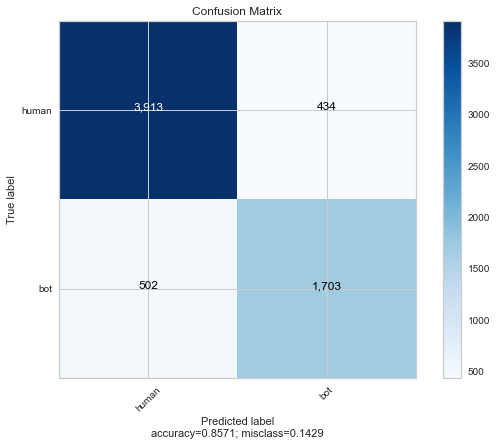

In [22]:
metrics_report(preds, y_val)

Classification Metrics Report
-----------------------------
Accuracy:  0.8605
Precision: 0.7758
Recall:    0.8049
F1 Score:  0.7901

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      4415
           1       0.78      0.80      0.79      2137

    accuracy                           0.86      6552
   macro avg       0.84      0.85      0.84      6552
weighted avg       0.86      0.86      0.86      6552




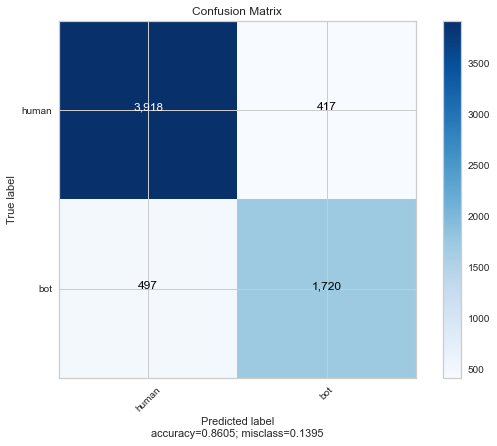

In [30]:
xgb = XGBClassifier(scale_pos_weight=estimate, 
                   tree_method='approx')

xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)

metrics_report(preds, y_val)

In [58]:
xgb = XGBClassifier(scale_pos_weight=estimate, 
                   tree_method='approx')

model_list = [xgb]
kf = KFold(n_splits=5, shuffle=True, random_state=33)

multi_model_eval(model_list, X, y, kf)

Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2.013118712273642,
              subsample=1, tree_method='approx', validate_parameters=1,
              verbosity=None)
------------------------------
Accuracy:  0.86350 +- 0.005646
Precision: 0.78572 +- 0.010845
Recall:    0.81295 +- 0.008397
F1 Score:  0.79909 +- 0.008964
ROC AUC:   0.92654 +- 0.003916



Average AUC Score: 0.9265 +- 0.003916


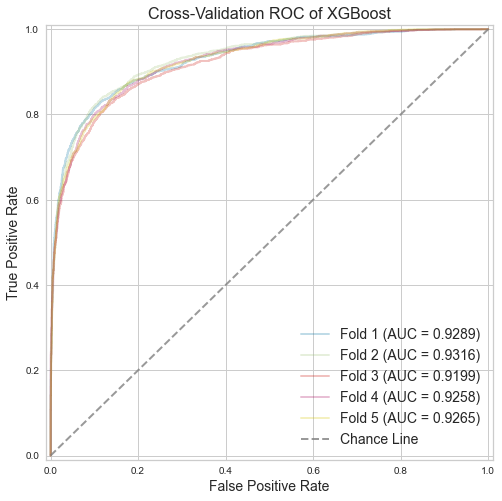

In [59]:
roc_curve_cv(xgb, X, y, kf, model_alias='XGBoost')

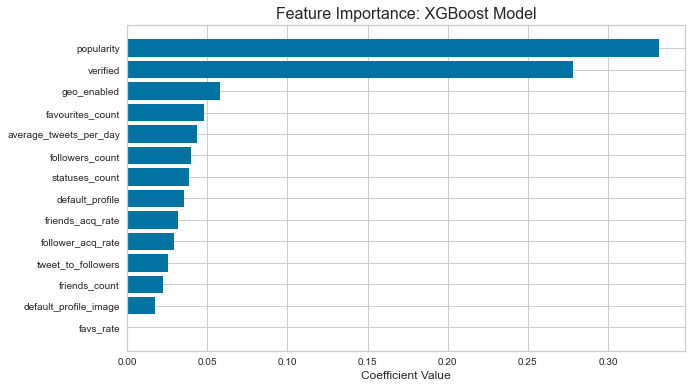

In [60]:
# set up feature_importance
importance = xgb.feature_importances_
feature_importance = list(zip(features, importance))

feature_importance.sort(key = lambda x: x[1])

# split sorted features_importance into x,y
feat = [f[0] for f in feature_importance]
imp = [i[1] for i in feature_importance]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title('Feature Importance: XGBoost Model', fontsize=16)
plt.barh(feat, imp)
plt.xlabel('Coefficient Value', fontsize=12);